<a href="https://colab.research.google.com/github/lucastanger/vehicle_classification/blob/main/vehicle_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidencetheory / Dempsters Rule

In [ ]:
!pip install py_dempster_shafer

In [ ]:
# Imports
import pandas as pd
from pyds import MassFunction

# Settings

In [ ]:
#@title Define classification bounds
# 
SPEED_LOWER_BOUND = 60 #@param {type:"integer"}
SPEED_UPPER_BOUND = 90 #@param {type:"integer"}
#@markdown ---
REFLECT_LOWER_BOUND = 0.1 #@param {type:"number"}
REFLECT_UPPER_BOUND = 0.6 #@param {type:"number"}
#@markdown ---
CAR_WIDTH_LOWER_BOUND = 1.6 #@param {type:"number"}
CAR_WIDTH_UPPER_BOUND = 2.15 #@param {type:"number"}
#@markdown ---
TRUCK_WIDTH_LOWER_BOUND = 1.9 #@param {type:"number"}
TRUCK_WIDTH_UPPER_BOUND = 2.5 #@param {type:"number"}
#@markdown ---
TWOWHEEL_WIDTH_LOWER_BOUND = 0.7 #@param {type:"number"}
TWOWHEEL_WIDTH_UPPER_BOUND = 1.1 #@param {type:"number"}
#@markdown ---
DISTANCE_PERCENTAGE_THRESHOLD = 1.05 #@param {type:"number"}

# Load data

We received 6 datasets, containing different radar measurements. The data consists of the following features:

* Takt (*Clock*) - A 100ms interval
* Radar/Distanz (*Radar/Distance in meters*) - The distance to the object in front
* Breite (*Width in meters*) - The width of the object in front
* Reflektionsstärke (*Reflection strength*) - The measured reflection strength of the object in front
* Geschwindigkeit (*Speed/Velocity*) - The measured velocity of the object in front

In [ ]:
dfs = []

# Load data iteratively
for i in range(1, 7):
  # Store dataframes in list for later access
  dfs.append(pd.read_csv('https://raw.githubusercontent.com/lucastanger/vehicle_classification/main/data/DE11_{}.csv'.format(i), sep=";"))

# Print out the head of the dataframes
for df in dfs: print(df.head(3))

   Takt Radar / Distanz (m) Breite (m) Reflektionsstaerke Geschwindigkeit
0     1                61,2      0,735           0,050715          119,56
1     2                60,8       0,63         0,03803625          119,92
2     3                60,5       0,42           0,050715          120,64
   Takt Radar / Distanz (m) Breite (m) Reflektionsstaerke Geschwindigkeit
0     1                  75       2,52              0,432           81,36
1     2                75,1        2,4             0,4032           81,36
2     3                75,2       2,52               0,36              81
   Takt Radar / Distanz (m) Breite (m) Reflektionsstaerke Geschwindigkeit
0     1                  60        1,1              0,072            90,5
1     2                  58        1,2              0,069            82,8
2     3                  56       1,21              0,073            82,8
   Takt Radar / Distanz (m) Breite (m) Reflektionsstaerke Geschwindigkeit
0     1                  40       0,86

In [ ]:
# Define omega
# p = PKW
# l = LKW
# m = Motorrad
# f = Fahrrad
omega = 'plmf'

Vorliegende Daten:

* **Geschwindigkeit** - Mittlere Geschwindigkeiten von 60-90
km/h sprechen für PKW, LKW oder
Motorrad. Höhere Geschwindigkeiten
über 90 km/h sprechen für PKW oder
Motorrad. 

* **Distanz** - Distanz zum vorausfahrenden Objekt - Sehr schnell schwankende Änderungen der Distanz (bei gleichbleibender
Eigengeschwindigkeit, d.h. Beschleunigungen), weisen auf ein Motorrad
hin, schnelle auf einen PKW oder
Motorrad.

* **Breite (m)** - Breiten zwischen 1,60 und 2,15
weisen auf PKW hin, Breiten zwischen 1,90 und 2,50 auf einen LKW
und Breiten zwischen 0,70 und 1,10
auf ein Motorrad oder ein Fahrrad.

* **Reflektionsstaerke** - LKW und PKW liefern eine große
Reflektionsstärke. Motorräder und
Fahrräder liefern deutlich geringere
Reflektionsstärken.



In [ ]:
def speed(speed: float) -> str: 
  """Classify a given speed. Limits are defined by lower and upper bounds"""
  if speed <= SPEED_LOWER_BOUND:
    return 'f'
  elif SPEED_LOWER_BOUND < speed < SPEED_UPPER_BOUND:
    return 'plm'
  elif speed >= SPEED_UPPER_BOUND:
    return 'pm'

def reflective_strength(reflective_strength: float) -> str:
  """Classify a given reflective strength. Limits are defined by lower and upper bounds"""
  if reflective_strength < REFLECT_LOWER_BOUND:
    return 'fm'
  elif REFLECT_LOWER_BOUND <= reflective_strength <= REFLECT_UPPER_BOUND:
    return 'pl'
  elif reflective_strength > REFLECT_UPPER_BOUND:
    return 'l'

def width(width: float) -> str:
  """Classify a given width. Limits are definied by lower and upper bounds"""
  if CAR_WIDTH_LOWER_BOUND <= width <= CAR_WIDTH_UPPER_BOUND:
    return 'p'
  elif TRUCK_WIDTH_LOWER_BOUND <= width <= TRUCK_WIDTH_UPPER_BOUND:
    return 'l'
  elif TWOWHEEL_WIDTH_LOWER_BOUND <= width <= TWOWHEEL_WIDTH_UPPER_BOUND:
    return 'fm'
  else:
    # Return nothing if measurement is meaningless
    return ''

def distance(distance: float, old_distance: float) -> str:
  """Classify a given distance by its predecessor"""
  # Check if ahead driving object gained x% of distance within 100ms
  if distance > old_distance*DISTANCE_PERCENTAGE_THRESHOLD:
    return 'm'
  else:
    return ''


Laut Aufgabenbeschreibung funktionieren die Sensoren im Nahbereich gut und werden auf Entfernung immer schlechter. 

**Assumption:** Evidence increases as a function of distance:

evidence = 1 - distance/2 /100

omega = 1 - evidence



In [ ]:
def compute_evidence(distance: float) -> float:
  """Compute an evidence value dependent on a given distance"""
  return 1-distance/2/100

In [ ]:
def createMassFunction(om: list, distance: float) -> MassFunction:
  """ Wrapper function for creation of pyds MassFunction """
  # Remove empty elements
  om = list(filter(None, om)) 
  # Remove duplicates
  om = list(dict.fromkeys(om))
  # Create param list
  param = {}

  # Iterate over all elements of omega
  for elem in om:
    # Create param entry with computed evidence score
    param[elem] = compute_evidence(distance=distance)/len(om)

  # Set omega as the counter probability of the evidence
  param[omega] = 1 - compute_evidence(distance=distance)

  return MassFunction(param)

In [ ]:
# TODO Dataset 0 FEHLER

In [ ]:
#@title Select dataset
# Storage of distance predecessor
old_dist = 0
# Storage of all mass functions
mass_functions = []
# Select the dataset
dataset_number = 2 #@param ["0", "1", "2", "3", "4", "5"] {type:"raw"}

for row in dfs[dataset_number].iloc:
  # Omega, which is calculated using the measurement limits
  omega_ = []
  # Iterate over the features
  for i in range(1,5):
    # Reformat for float casting
    s = row[i].replace(',', '.')
    # Feature 1: Distance
    if i == 1:
      # If there is no predecessor
      if old_dist == 0:
        # Get object prediction for distance
        omega_.append(distance(float(s), float(s)))
        # Set current distance as predecessor
        old_dist = float(s)
      # If there is a predecessor
      else:
        # Get object prediction for distance
        omega_.append(distance(float(s), old_dist))
        # Set current distance as predecessor
        old_dist = float(s)
      # Feature 2: Width
    elif i == 2:
      # Get object prediction for width
      omega_.append(width(float(s)))
    # Feature 3: Reflective Strength
    elif i == 3:
      # Get object prediction for reflective strength
      omega_.append(reflective_strength(float(s)))
    # Feature 4: Speed/Velocity
    elif i == 4:
      # Get object prediction for speed
      omega_.append(speed(float(s)))

  # Print current iteration
  print(f'Takt {row[0]}: {omega_}')
  # Append the newly created massfunction to the list
  mass_functions.append(createMassFunction(omega_, float(row[1].replace(',', '.'))))

Takt 1: ['', 'fm', 'fm', 'pm']
Takt 2: ['', '', 'fm', 'plm']
Takt 3: ['', '', 'fm', 'plm']
Takt 4: ['', 'fm', 'fm', 'plm']
Takt 5: ['', 'fm', 'fm', 'plm']
Takt 6: ['', '', 'fm', 'pm']
Takt 7: ['', 'fm', 'fm', 'pm']
Takt 8: ['', 'fm', 'fm', 'plm']
Takt 9: ['', '', 'fm', 'pm']
Takt 10: ['', 'fm', 'fm', 'pm']
Takt 11: ['', 'fm', 'fm', 'pm']
Takt 12: ['m', '', 'fm', 'pm']
Takt 13: ['m', '', 'fm', 'pm']
Takt 14: ['m', 'fm', 'fm', 'pm']
Takt 15: ['m', 'fm', 'fm', 'pm']
Takt 16: ['m', 'fm', 'fm', 'pm']
Takt 17: ['m', 'fm', 'fm', 'pm']
Takt 18: ['m', '', 'fm', 'pm']
Takt 19: ['m', 'fm', 'fm', 'pm']
Takt 20: ['m', 'fm', 'fm', 'pm']


In [ ]:
# Show all massfunctions (without dempster rule applied to them)
for i, fun in enumerate(mass_functions):
  print(f'MassFuntion at {i*100}ms: {fun}')

MassFuntion at 0ms: {{'f', 'm'}:0.35; {'p', 'm'}:0.35; {'f', 'p', 'm', 'l'}:0.30000000000000004}
MassFuntion at 100ms: {{'f', 'm'}:0.355; {'p', 'm', 'l'}:0.355; {'f', 'p', 'm', 'l'}:0.29000000000000004}
MassFuntion at 200ms: {{'f', 'm'}:0.36; {'p', 'm', 'l'}:0.36; {'f', 'p', 'm', 'l'}:0.28}
MassFuntion at 300ms: {{'f', 'm'}:0.365; {'p', 'm', 'l'}:0.365; {'f', 'p', 'm', 'l'}:0.27}
MassFuntion at 400ms: {{'f', 'm'}:0.3675; {'p', 'm', 'l'}:0.3675; {'f', 'p', 'm', 'l'}:0.265}
MassFuntion at 500ms: {{'f', 'm'}:0.3675; {'p', 'm'}:0.3675; {'f', 'p', 'm', 'l'}:0.265}
MassFuntion at 600ms: {{'f', 'm'}:0.37; {'p', 'm'}:0.37; {'f', 'p', 'm', 'l'}:0.26}
MassFuntion at 700ms: {{'f', 'm'}:0.3725; {'p', 'm', 'l'}:0.3725; {'f', 'p', 'm', 'l'}:0.255}
MassFuntion at 800ms: {{'f', 'm'}:0.37; {'p', 'm'}:0.37; {'f', 'p', 'm', 'l'}:0.26}
MassFuntion at 900ms: {{'f', 'm'}:0.36875; {'p', 'm'}:0.36875; {'f', 'p', 'm', 'l'}:0.26249999999999996}
MassFuntion at 1000ms: {{'f', 'm'}:0.3625; {'p', 'm'}:0.3625; {'f',

# Dempster Rule

In [ ]:
dempster_list = []

# Empty object for storage of massfunction predecessor
c = None
# Iterate over all functions
for i, func in enumerate(mass_functions):
  # If there is no predecessor 
  if i == 0:
    # Set current function as predecessor
    c = func
  else:
    # Apply dempster rule on predecessor
    print(c)
    print(mass_functions[i], "\n")
    c = c.combine_conjunctive(mass_function=mass_functions[i])

  # Iteratively print massfunctions
  #print(f'{c}')
  dempster_list.append(c)

# Show final massfunction
print(f'Final Massfunction: {c}')

{{'f', 'm'}:0.35; {'p', 'm'}:0.35; {'f', 'p', 'm', 'l'}:0.30000000000000004}
{{'f', 'm'}:0.355; {'p', 'm', 'l'}:0.355; {'f', 'p', 'm', 'l'}:0.29000000000000004} 

{{'f', 'm'}:0.33225000000000005; {'m'}:0.24849999999999997; {'p', 'm'}:0.22575; {'p', 'm', 'l'}:0.10650000000000001; {'f', 'p', 'm', 'l'}:0.08700000000000002}
{{'f', 'm'}:0.36; {'p', 'm', 'l'}:0.36; {'f', 'p', 'm', 'l'}:0.28} 

{{'m'}:0.48771999999999993; {'f', 'm'}:0.24396000000000004; {'p', 'm'}:0.14448; {'p', 'm', 'l'}:0.09948000000000001; {'f', 'p', 'm', 'l'}:0.02436000000000001}
{{'f', 'm'}:0.365; {'p', 'm', 'l'}:0.365; {'f', 'p', 'm', 'l'}:0.27} 

{{'m'}:0.6658108; {'f', 'm'}:0.16380600000000003; {'p', 'm'}:0.0917448; {'p', 'm', 'l'}:0.07206120000000002; {'f', 'p', 'm', 'l'}:0.006577200000000004}
{{'f', 'm'}:0.3675; {'p', 'm', 'l'}:0.3675; {'f', 'p', 'm', 'l'}:0.265} 

{{'m'}:0.7862082099999999; {'f', 'm'}:0.106024416; {'p', 'm'}:0.05802858599999999; {'p', 'm', 'l'}:0.047995829999999996; {'f', 'p', 'm', 'l'}:0.001742958

In [ ]:
dempster_list[-1]

{frozenset({'m'}): 0.9994185374032996,
 frozenset({'f', 'm'}): 0.00029073006235274043,
 frozenset({'m', 'p'}): 0.00029055894247309165,
 frozenset({'l', 'm', 'p'}): 1.7111987964889113e-07,
 frozenset({'f', 'l', 'm', 'p'}): 2.471994879169409e-09}

In [ ]:
def compute_plausibility(mass_function: MassFunction) -> None:
  for elem in omega:
    # Print out every possible plausibility in omega
    print(f'Plausibility of {elem}: {mass_function.pl({elem})}')

def compute_belief(mass_function: MassFunction) -> None:
  for elem in omega:
    # Print out every possible believe in omega
    print(f'B({elem}): {mass_function.bel({elem})}')

  # Some additional believes
  print(f'B(four wheels) = B(p,l) = {c.bel("pl")}')
  print(f'B(two wheels) = B(f,m) = {c.bel("fm")}')

def compute_doubt(mass_function: MassFunction, lbl: str) -> None: 
  # Print doubt of massfunction with given label
  print(f'Doubt on classification of {lbl}: {mass_function.bel(omega.replace(lbl, ""))}')

In [ ]:
compute_plausibility(c)

Plausibility of p: 0.00029073253434761973
Plausibility of l: 1.7359187452806054e-07
Plausibility of m: 0.9999999999999999
Plausibility of f: 0.0002907325343476196


In [ ]:
compute_belief(c)

B(p): 0.0
B(l): 0.0
B(m): 0.9994185374032996
B(f): 0.0
B(four wheels) = B(p,l) = 0.0
B(two wheels) = B(f,m) = 0.9997092674656523


In [ ]:
#@title Compute Doubt for given label
doubt = "m" #@param ["p", "l", "m", "f"]

compute_doubt(c, doubt)

Doubt on classification of m: 0.0


# Evaluation

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
mass_functions

[{frozenset({'f', 'm'}): 0.35,
  frozenset({'m', 'p'}): 0.35,
  frozenset({'f', 'l', 'm', 'p'}): 0.30000000000000004},
 {frozenset({'f', 'm'}): 0.355,
  frozenset({'l', 'm', 'p'}): 0.355,
  frozenset({'f', 'l', 'm', 'p'}): 0.29000000000000004},
 {frozenset({'f', 'm'}): 0.36,
  frozenset({'l', 'm', 'p'}): 0.36,
  frozenset({'f', 'l', 'm', 'p'}): 0.28},
 {frozenset({'f', 'm'}): 0.365,
  frozenset({'l', 'm', 'p'}): 0.365,
  frozenset({'f', 'l', 'm', 'p'}): 0.27},
 {frozenset({'f', 'm'}): 0.3675,
  frozenset({'l', 'm', 'p'}): 0.3675,
  frozenset({'f', 'l', 'm', 'p'}): 0.265},
 {frozenset({'f', 'm'}): 0.3675,
  frozenset({'m', 'p'}): 0.3675,
  frozenset({'f', 'l', 'm', 'p'}): 0.265},
 {frozenset({'f', 'm'}): 0.37,
  frozenset({'m', 'p'}): 0.37,
  frozenset({'f', 'l', 'm', 'p'}): 0.26},
 {frozenset({'f', 'm'}): 0.3725,
  frozenset({'l', 'm', 'p'}): 0.3725,
  frozenset({'f', 'l', 'm', 'p'}): 0.255},
 {frozenset({'f', 'm'}): 0.37,
  frozenset({'m', 'p'}): 0.37,
  frozenset({'f', 'l', 'm', 'p'}

In [ ]:
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = [value]

In [ ]:
def correct_data(dict_obj):
  max_key = max(dict_obj, key= lambda x: len(set(dict_obj[x])))
  for key, value in dict_obj.items():
    missing_values = len(dict_obj[max_key])-len(value)
    for _ in range(missing_values):
      dict_obj[key].insert(0, None)
  return dict_obj

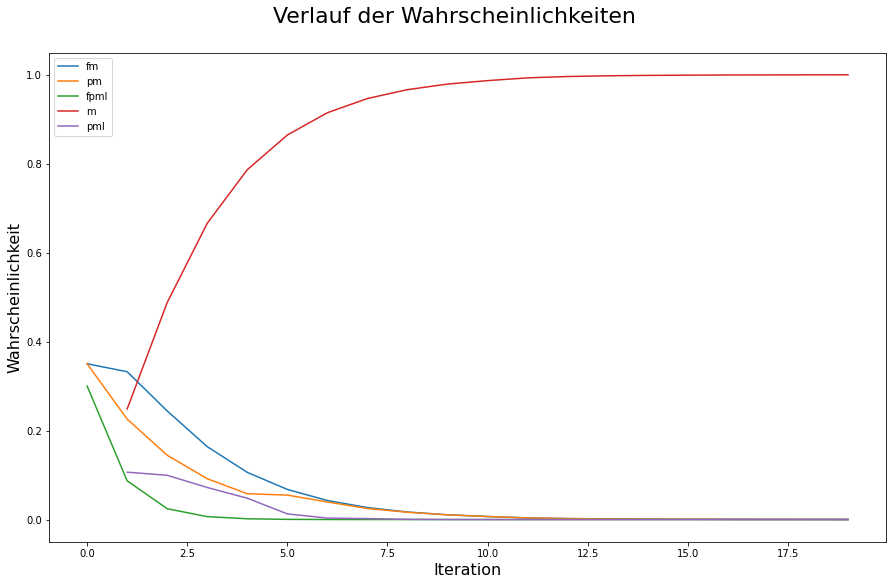

In [186]:
dic = {}

for mf in dempster_list:
  for i in mf:
    val = mf[i]
    key = ''.join(list(i))
    # dic[key] = [val]
    append_value(dic, key, val)

dic = correct_data(dic)
d = pd.DataFrame(dic)

fig = plt.figure(figsize=(15,9))
plt.plot(d)
fig.suptitle('Verlauf der Wahrscheinlichkeiten', fontsize=22, y=0.95)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Wahrscheinlichkeit', fontsize=16)
plt.legend(d)
plt.show()

In [ ]:
d

,fm,pm,fpml,m,pml
0,0.350000,0.350000,3.000000e-01,NaN,NaN
1,0.332250,0.225750,8.700000e-02,0.248500,1.065000e-01
2,0.243960,0.144480,2.436000e-02,0.487720,9.948000e-02
3,0.163806,0.091745,6.577200e-03,0.665811,7.206120e-02
4,0.106024,0.058029,1.742958e-03,0.786208,4.799583e-02
5,0.067701,0.054982,4.618839e-04,0.864136,1.271889e-02
6,0.042823,0.039516,1.200898e-04,0.914235,3.306913e-03
7,0.026916,0.024796,3.062290e-05,0.946138,2.119821e-03
8,0.016968,0.016417,7.961954e-06,0.966055,5.511535e-04
9,0.010714,0.010570,2.090013e-06,0.978570,1.446778e-04
